In [7]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime

### Generate Dataset

In [13]:
# set ticker
ticker = "SPY"

# set timeframe for data
start = '2020-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
stock_data = stock_data.drop(columns=['Adj Close'])
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000


### Filter the dataset

In [14]:
# Filter the date index and close columns
val_signals_df = stock_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
val_signals_df["Actual Returns"] = val_signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
val_signals_df = val_signals_df.dropna()

# Review the DataFrame
display(val_signals_df.head())
display(val_signals_df.tail())

,Close,Actual Returns
Date,,
2020-01-03,322.410004,-0.007572
2020-01-06,323.640015,0.003815
2020-01-07,322.730011,-0.002812
2020-01-08,324.450012,0.005330
2020-01-09,326.649994,0.006781


,Close,Actual Returns
Date,,
2020-12-24,369.000000,0.003890
2020-12-28,372.170013,0.008591
2020-12-29,371.459991,-0.001908
2020-12-30,371.989990,0.001427
2020-12-31,373.880005,0.005081


## Generate trading signals

### Split the data into training and testing datasets.

In [18]:
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
val_signals_df['fast_close'] = val_signals_df['Close'].ewm(halflife=short_window).mean()
val_signals_df['slow_close'] = val_signals_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
val_signals_df['crossover_long'] = np.where(val_signals_df['fast_close'] > val_signals_df['slow_close'], 1.0, 0.0)
val_signals_df['crossover_short'] = np.where(val_signals_df['fast_close'] < val_signals_df['slow_close'], -1.0, 0.0)
val_signals_df['crossover_signal'] = val_signals_df['crossover_long'] + val_signals_df['crossover_short']

val_signals_df.head()





,Close,Actual Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
2020-01-03,322.410004,-0.007572,322.410004,322.410004,0.0,0.0,0.0
2020-01-06,323.640015,0.003815,323.230011,323.046315,1.0,0.0,1.0
2020-01-07,322.730011,-0.002812,322.944297,322.933494,1.0,0.0,1.0
2020-01-08,324.450012,0.005330,323.747345,323.352904,1.0,0.0,1.0
2020-01-09,326.649994,0.006781,325.245486,324.106749,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

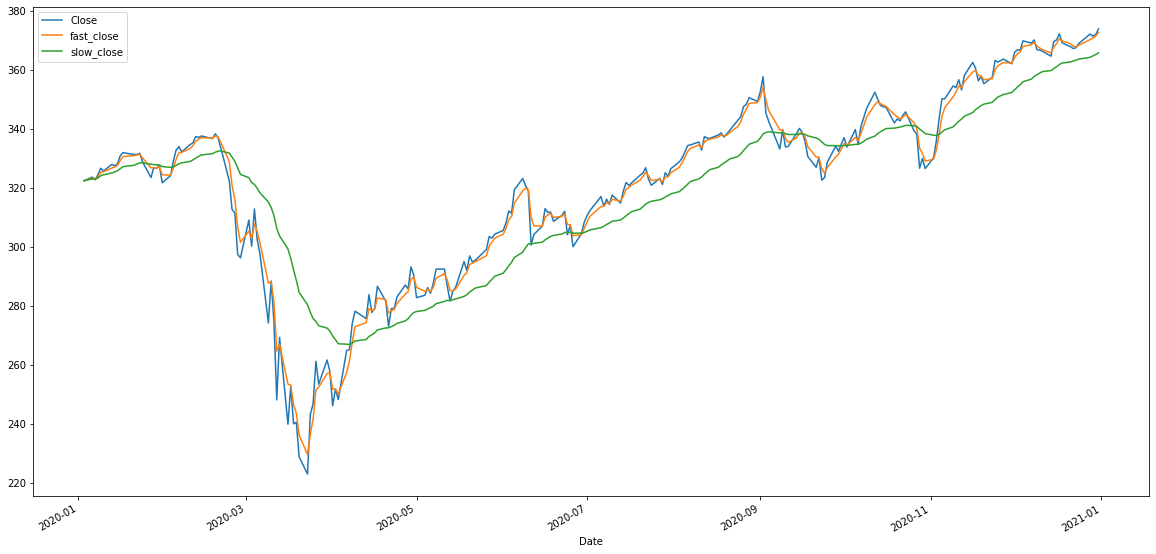

In [19]:
# Plot the EMA of closing prices
val_signals_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [21]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively



val_signals_df['fast_vol'] = val_signals_df['Actual Returns'].ewm(halflife=short_vol_window).std()
val_signals_df['slow_vol'] = val_signals_df['Actual Returns'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
val_signals_df['vol_trend_long'] = np.where(val_signals_df['fast_vol'] < val_signals_df['slow_vol'], 1.0, 0.0)
val_signals_df['vol_trend_short'] = np.where(val_signals_df['fast_vol'] > val_signals_df['slow_vol'], -1.0, 0.0) 
val_signals_df['vol_trend_signal'] = val_signals_df['vol_trend_long'] + val_signals_df['vol_trend_short']

val_signals_df

,Close,Actual Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,
2020-01-03,322.410004,-0.007572,322.410004,322.410004,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2020-01-06,323.640015,0.003815,323.230011,323.046315,1.0,0.0,1.0,0.008052,0.008052,0.0,0.0,0.0
2020-01-07,322.730011,-0.002812,322.944297,322.933494,1.0,0.0,1.0,0.005005,0.005633,1.0,0.0,1.0
2020-01-08,324.450012,0.005330,323.747345,323.352904,1.0,0.0,1.0,0.005471,0.005925,1.0,0.0,1.0
2020-01-09,326.649994,0.006781,325.245486,324.106749,1.0,0.0,1.0,0.004739,0.005972,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.000000,0.003890,368.406283,363.692171,1.0,0.0,1.0,0.003814,0.007606,1.0,0.0,1.0
2020-12-28,372.170013,0.008591,370.288148,364.259907,1.0,0.0,1.0,0.005050,0.007591,1.0,0.0,1.0
2020-12-29,371.459991,-0.001908,370.874070,364.742075,1.0,0.0,1.0,0.005585,0.007386,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

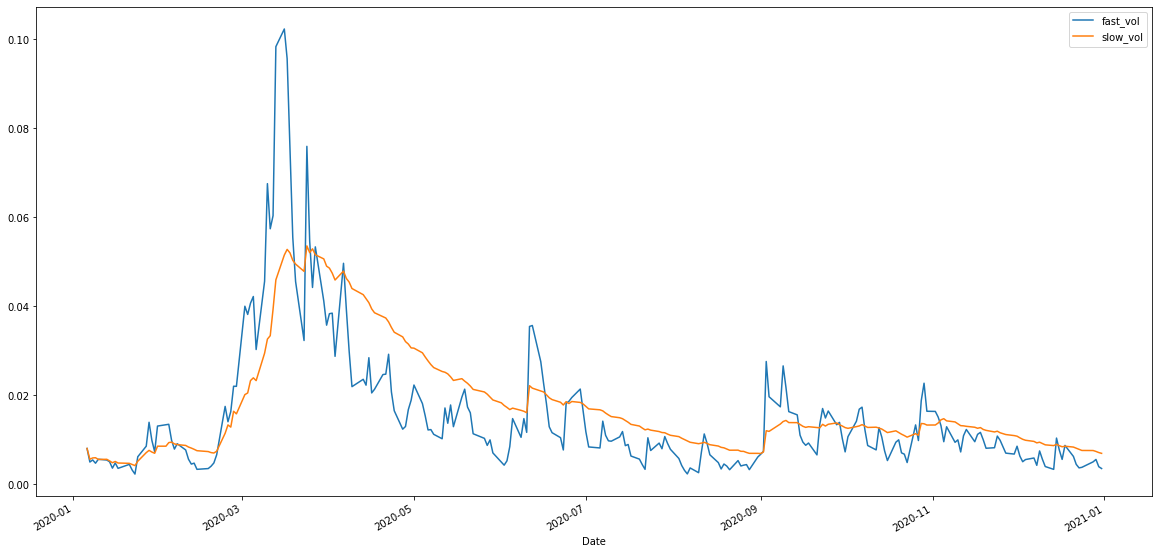

In [22]:
val_signals_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [30]:
# Generate the short and long moving averages (50 and 100 days, respectively)
val_signals_df["SMA50"] = val_signals_df["Close"].rolling(window=short_window).mean()
val_signals_df["SMA100"] = val_signals_df["Close"].rolling(window=long_window).mean()
val_signals_df["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
val_signals_df["Signal"][short_window:] = np.where(
    val_signals_df["SMA50"][short_window:] > val_signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
val_signals_df["Entry/Exit"] = val_signals_df["Signal"].diff()

val_signals_df.head(10)

,Close,Actual Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,SMA50,SMA100,Signal,Entry/Exit
Date,,,,,,,,,,,,,,,,
2020-01-03,322.410004,-0.007572,322.410004,322.410004,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,322.410004,NaN,0.0,NaN
2020-01-06,323.640015,0.003815,323.230011,323.046315,1.0,0.0,1.0,0.008052,0.008052,0.0,0.0,0.0,323.640015,NaN,0.0,0.0
2020-01-07,322.730011,-0.002812,322.944297,322.933494,1.0,0.0,1.0,0.005005,0.005633,1.0,0.0,1.0,322.730011,NaN,0.0,0.0
2020-01-08,324.450012,0.005330,323.747345,323.352904,1.0,0.0,1.0,0.005471,0.005925,1.0,0.0,1.0,324.450012,NaN,0.0,0.0
2020-01-09,326.649994,0.006781,325.245486,324.106749,1.0,0.0,1.0,0.004739,0.005972,1.0,0.0,1.0,326.649994,NaN,0.0,0.0
2020-01-10,325.709991,-0.002878,325.481425,324.422299,1.0,0.0,1.0,0.005629,0.005585,0.0,-1.0,-1.0,325.709991,NaN,0.0,0.0
2020-01-13,327.950012,0.006877,326.725438,325.036823,1.0,0.0,1.0,0.005453,0.005618,1.0,0.0,1.0,327.950012,NaN,0.0,0.0
2020-01-14,327.450012,-0.001525,327.089146,325.416487,1.0,0.0,1.0,0.005059,0.005262,1.0,0.0,1.0,327.450012,NaN,0.0,0.0
2020-01-15,328.190002,0.002260,327.640651,325.816678,1.0,0.0,1.0,0.003635,0.004846,1.0,0.0,1.0,328.190002,NaN,0.0,0.0


In [31]:
# Visualize exit position relative to close price
exit = val_signals_df[val_signals_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = val_signals_df[val_signals_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = val_signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize moving averages
moving_avgs = val_signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)